# Aggregate gridded data over geometry files

This notebook will demonstrate how to use the earthkit libraries to access some ERA5 data, perform some aggregations over geometry files then plot the results.

For this exercise we will use the earthkit-data package to access the data, earthkit-climate to calculate our climatologies and anomalies and earthkit-maps to plot the results. We will also access some geometries that we have stored for testing purposes.

The earthkit-climate routines are *currently* based on xarray, hence they return raw xarray objects. *This may change in future versions of Earthkit*.

In [1]:
import numpy as np # Everyone loves a numpy!

from earthkit import data as ek_data
from earthkit.climate import aggregate as ek_aggregate
from earthkit import maps as ek_maps

# For this example we are going to use some geometry files we have stored for testing,
# but any geojson files or geopandas dataframes would work.
from earthkit.data.testing import earthkit_remote_test_data_file

import warnings
warnings.filterwarnings("ignore")

In [2]:
cds_dataset_name = 'reanalysis-era5-single-levels'

# We use an Earthkit bounding box object to describe our area, this clears up any lack of clarity of the order of
#  North, South, East, West.

area = ek_data.utils.bbox.BoundingBox(north=80, south=20, west=-30, east=100)
cds_request = {
    'product_type': 'reanalysis',
    'variable': '2m_temperature',
    'year': [
        "2015",
    ],
    'month': [
        '01', '02', '03',
        '04', '05', '06',
        '07', '08', '09',
        '10', '11', '12',
    ],
    'day': [
        '01', '02', '03',
        '04', '05', '06',
        '07', '08', '09',
        '10', '11', '12',
        '13', '14', '15',
        '16', '17', '18',
        '19', '20', '21',
        '22', '23', '24',
        '25', '26', '27',
        '28', '29', '30',
        '31',
    ],
    'time': [
        '00:00', '06:00', '12:00', '18:00',
    ],
    'area': area
}
# ear5_data.save('data/era5-t2m-Europe-2000_2022.grib')
era5_data = ek_data.from_source("cds", cds_dataset_name, cds_request)


## Load your NUTS

Load the NUTS geometries from the geojson file we have stored in our test data repository. Visualising as a pandas dataframe is preferable.

In [3]:
# Use some demonstration polygons stored, this could be any url or path to geojson file
remote_nuts_url = earthkit_remote_test_data_file("test-data", "NUTS_RG_60M_2021_4326_LEVL_0.geojson")
nuts_data = ek_data.from_source("url", remote_nuts_url)

nuts_data.to_pandas()[:5]

,id,NUTS_ID,LEVL_CODE,CNTR_CODE,NAME_LATN,NUTS_NAME,MOUNT_TYPE,URBN_TYPE,COAST_TYPE,FID,geometry
0,DK,DK,0,DK,Danmark,Danmark,0,0,0,DK,"MULTIPOLYGON (((15.16290 55.09370, 15.09400 54..."
1,RS,RS,0,RS,Serbia,Srbija/Сpбија,0,0,0,RS,"POLYGON ((21.47920 45.19300, 21.35850 44.82160..."
2,EE,EE,0,EE,Eesti,Eesti,0,0,0,EE,"MULTIPOLYGON (((27.35700 58.78710, 27.64490 57..."
3,EL,EL,0,EL,Elláda,Ελλάδα,0,0,0,EL,"MULTIPOLYGON (((28.07770 36.11820, 27.86060 35..."
4,ES,ES,0,ES,España,España,0,0,0,ES,"MULTIPOLYGON (((4.39100 39.86170, 4.19070 39.7..."


## Mask dataarray with geodataframe

`shapes.mask` applies all the features in the geometry object (`nuts_data`) to the data object (`era5_data`).
It returns an xarray object the same shape and type as the input xarray object with all points outside of
the geometry masked

In [4]:
single_masked_data = ek_aggregate.spatial.mask(era5_data, nuts_data)
single_masked_data

<xarray.Dataset>
Dimensions:     (number: 1, time: 1460, step: 1, surface: 1, latitude: 241,
                 longitude: 521)
Coordinates:
  * number      (number) int64 0
  * time        (time) datetime64[ns] 2015-01-01 ... 2015-12-31T18:00:00
  * step        (step) timedelta64[ns] 00:00:00
  * surface     (surface) float64 0.0
  * latitude    (latitude) float64 80.0 79.75 79.5 79.25 ... 20.5 20.25 20.0
  * longitude   (longitude) float64 -30.0 -29.75 -29.5 ... 99.5 99.75 100.0
    valid_time  (time, step) datetime64[ns] ...
Data variables:
    t2m         (number, time, step, surface, latitude, longitude) float32 na...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-09-05T15:28 GRIB to CDM+CF via cfgrib-0.9.1...

Then plot what we have done:

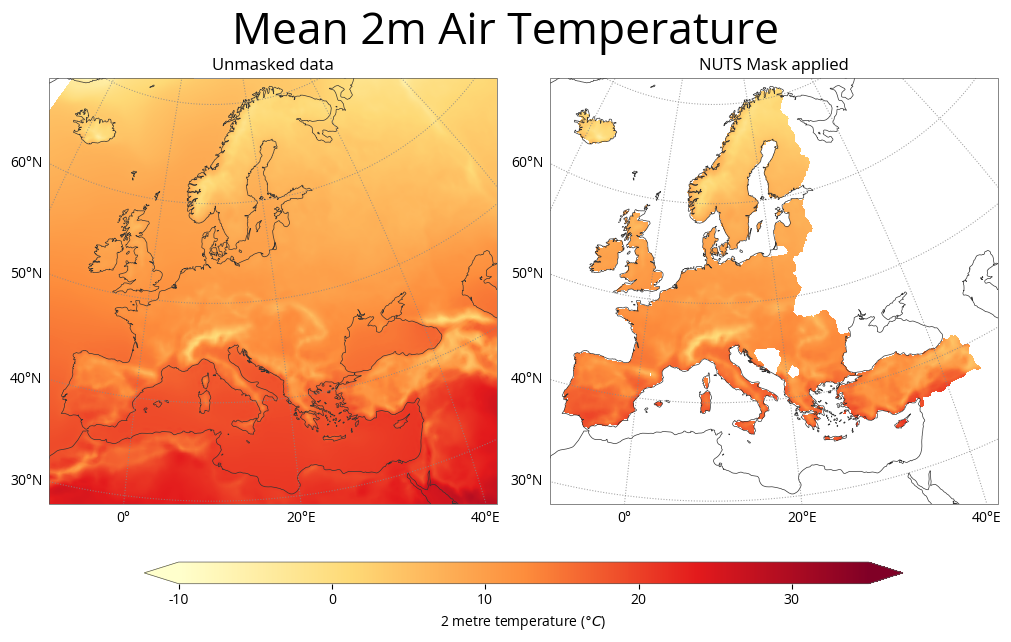

In [13]:
# We take the mean of our data in the time dimension for plotting purposes
mean_era5 = era5_data.to_xarray().t2m
mean_era5 = mean_era5.mean(dim='time').assign_attrs(mean_era5.attrs)

mean_masked_data = single_masked_data.t2m.mean(dim='time').assign_attrs(single_masked_data.t2m.attrs)

style = ek_maps.styles.Contour(
    colors=["#ffffcc","#fed976","#fd8d3c","#e31a1c","#800026"],  # Or provide a list of colours to interpolate
    levels=np.arange(-10, 35.01, 0.1),
    units="celsius",
    extend='both',  # How to handle out-of-bounds values, can be None (default), 'min', 'max' ot 'both'
    # The legend/colorbar ticks can be included here or when the legend is added
    ticks=np.arange(-10,36,10)
)

# Plot the 2 objects
chart = ek_maps.Superplot(domain="Europe", rows=1, cols=2)

subplot1 = chart.add_subplot()
subplot1.plot(mean_era5, style=style)
subplot1.title("Unmasked data")

subplot2 = chart.add_subplot()
subplot2.plot(mean_masked_data, style=style)
subplot2.title("NUTS Mask applied")

# earthkit maps is actually clever to figure all this out for you:
# chart = ek_maps.Superplot(domain="Europe")
# chart.plot([mean_era5, mean_masked_data], style=style)
# # Add subplot titles
# chart.subplot_titles("Unmasked data", "NUTS Mask applied")

# Ad chart title
chart.title("Mean 2m Air Temperature", fontsize=32, y=0.83)
# We can now add coastlines, gridlines and a legend
chart.coastlines(resolution='medium')
chart.gridlines()
chart.legend() # It is also possible to define the legend ticks here, this will override anything 

chart.show()

`shapes.masks` applies the features in the geometry object (`nuts_data`) to the data object (`era5_data`).
It returns an xarray object with an additional dimension, and coordinate variable, corresponding to the 
features in the geometry object.
By default this is the index of the input geodataframe, in this example the index is just an integer
count so it takes the default name `index`.

In [6]:
masked_data = ek_aggregate.spatial.masks(era5_data, nuts_data)
masked_data

KeyboardInterrupt: 

It is possible to specify a column in the geodataframe to use for the new dimension, for example in NUTS the
`FID` (= feature id) which contains the two letter identier code for each feature:

In [ ]:
masked_data = ek_aggregate.spatial.masks(era5_data, nuts_data, mask_dim="FID")
masked_data

: 

: 

And then plot the difference:

In [ ]:
# We take the mean of our data in the time dimension for plotting purposes
germany_data = masked_data.sel(FID='DE')
mean_germany_data = germany_data.t2m.mean(dim='time').assign_attrs(masked_data.t2m.attrs)
mean_germany_zoom_data = mean_germany_data.dropna(dim='latitude', how='all').dropna(dim='longitude', how='all')

plot_data = [mean_era5, mean_germany_data, mean_germany_zoom_data]
plot_titles = ["Unmasked data", "Germany Mask applied", "Germany mask applied (cutout)"]

style = ek_maps.styles.Contour(
    colors=["#ffffcc","#fed976","#fd8d3c","#e31a1c","#800026"],  # Or provide a list of colours to interpolate
    levels=np.arange(-10, 35.01, 0.1),
    units="celsius",
    extend='both',  # How to handle out-of-bounds values, can be None (default), 'min', 'max' ot 'both'
    # The legend/colorbar ticks can be included here or when the legend is added
    ticks=np.arange(-10,36,10)
)

# Plot the 2 objects
chart = ek_maps.Superplot(domain="Europe", rows=1)
chart.plot(plot_data, style=style)

# Add titles, subplot titles
chart.title("Mean 2m Air Temperature")
for subplot, ptitle in zip(chart, plot_titles):
    subplot.title(ptitle)

# We can now add coastlines, gridlines and a legend
chart.coastlines(resolution='medium')
chart.gridlines()
chart.legend() # It is also possible to define the legend ticks here, this will override anything 

chart.show()